In [1]:
import numpy as np
import h5py

import MDAnalysis as mda
from MDAnalysis import analysis

import importlib
import XS_calc
from XS_calc import *

import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib inline


In [49]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

#### Import experimental files for 1l2y

In [50]:
filename = "data/20220404_trpcage_reconstructed_saxs.h5"
h5 = h5py.File(filename)
print(h5.keys())

<KeysViewHDF5 ['q_SAD', 's_SAD', 's_SAD_err', 's_int', 's_int_err', 's_unf', 's_unf_err']>


In [51]:
# Set measurement q to experimental q
mea = Measurement(q = np.squeeze(h5['q_SAD'][:]))
print(np.shape(mea.q))

(136,)


In [4]:
# Create Experiment class objects for each species
F_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][0,:]), S_err = np.squeeze(h5['s_SAD_err'][0,:]))
U_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][1,:]), S_err = np.squeeze(h5['s_SAD_err'][1,:]))
I_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_int'][:]), S_err = np.squeeze(h5['s_int_err'][:]))
U_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_unf'][:]), S_err = np.squeeze(h5['s_unf_err'][:]))

<IPython.core.display.Javascript object>


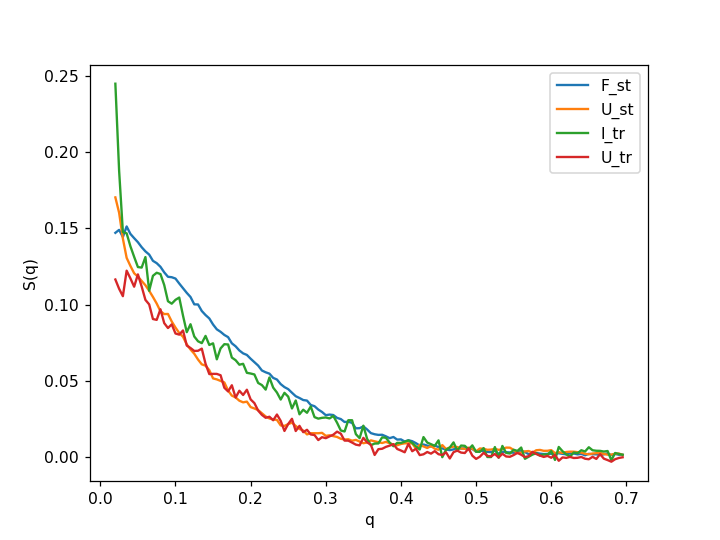

In [5]:
plt.figure()
plt.plot(F_st.q, F_st.S_exp, label="F_st")
plt.plot(U_st.q, U_st.S_exp, label="U_st")
plt.plot(I_tr.q, I_tr.S_exp, label="I_tr")
plt.plot(U_tr.q, U_tr.S_exp, label="U_tr")
plt.xlabel('q')
plt.ylabel('S(q)')
plt.legend()
plt.show()

#### Import the MD trajectory and perform XS calculation on trajectory

In [57]:
# This would be a typical use case

U = mda.Universe("data/1l2y_wb_ions.psf", "data/1l2y_unfold_300K.dcd")

# full trajectory
# traj = traj_slice(U, selection='protein')

# first 100 frames
traj = Trajectory_slice(U, selection="protein", frame_max = 10)

# This doesn't work yet... OverflowError: Python int too large to convert to C long
# every 50 frames
# traj = Trajectory_slice(U, selection="protein", frame_step=50)

print(np.shape(traj.Frames))

env = Environment()

# XS = traj_calc(traj, env, mea)
# print(np.shape(XS))
# Do something with XS. E.g. fitting etc.


The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
(10,)


In [31]:
frame_min = 0
frame_step = 50
num_of_frames = U.trajectory.n_frames
indices = [frame_min]
while indices[-1]+frame_step <= num_of_frames:
    indices.append(indices[-1]+frame_step)
    
print(indices)
print('There are {:.1f} frames'.format(len(indices)))

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100, 5150, 5200, 5250, 5300, 5350, 5400, 5450, 5500, 5550, 5600, 5650, 5700, 5750, 5800, 5850, 5900, 5950, 6000, 6050, 6100, 6150, 6200, 6250, 6300, 6350, 6400, 6450, 6500, 6550, 6600, 6650, 6700, 6750, 6800, 6850, 6900, 6950, 7000, 7050, 7100, 7150, 7200, 7250, 7300, 7350, 7400, 7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800, 7850, 7900, 7950, 8000, 8050, 8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450, 85

In [40]:
U.trajectory[indices]

In [59]:
# for each c1:
#   for each c2:
#     for each frame in trajectory:
#       calculate S_calc(q, c1, c2) of the frame
#     S_calc_avg = average S_calc over the frames
#     Fit the S_exp to S_calc_avg by minimizing chi^2 (c, a) = SUM_q ( S_calc_avg(q) - (c * S_exp(q) - a)  / S_err(q) ) ^2
#     Record the chi^2
# Find the lowest chi^2 within the (c1, c2) pairs

from scipy.optimize import minimize

c1_grid = np.arange(0.95, 1.051, 0.005)
# c2_grid = np.arange(-2.0, 4.01, 0.05)
c2_grid = np.arange(-2.0, 4.01, 0.5)

chi2_grid = np.zeros((len(c1_grid),len(c2_grid),3))

for c1_i, c1_val in enumerate(c1_grid):
    for c2_i, c2_val in enumerate(c2_grid):
        env_c_grid = Environment(c1=c1_val, c2=c2_val)
        XS = traj_calc(traj, env_c_grid, mea, "frame_XS_calc_fast")
        XS_avg = np.mean(XS, axis=0)
        chi2_fun = lambda x: np.sqrt(np.mean( ((XS_avg - (F_st.S_exp * x[0] + x[1]))/F_st.S_err)**2 ))
        res = minimize(chi2_fun, (1,0), method='CG')
        chi2_grid[c1_i, c2_i,:] = np.array([chi2_fun(res.x), res.x[0], res.x[1]])
        print(chi2_grid[c1_i, c2_i,:])
        
        

Done in 2.9695 seconds
[755191.79460978 380534.8021449    4274.67031978]
Done in 3.2935 seconds
[678387.76118552 515840.34888399   3480.43750512]
Done in 2.8980 seconds
[591489.10257555 669668.76070988   2614.39859014]
Done in 2.9181 seconds
[530928.77561128 842222.77004499   1672.06172419]
Done in 2.7112 seconds
[5.57750818e+05 1.03326504e+06 6.57751853e+02]
Done in 2.7854 seconds
[ 7.10230958e+05  1.24273289e+06 -4.25688946e+02]
Done in 2.8093 seconds
[ 970078.82906567 1470753.00029254   -1581.80027065]
Done in 2.7490 seconds
[1308538.28844407 1717418.49992322   -2812.75750786]
Done in 2.8471 seconds
[1709260.52880463 1982402.20351359   -4110.5332166 ]
Done in 2.7697 seconds
[2164395.09374744 2266357.53875742   -5492.87342949]
Done in 2.8193 seconds
[2670064.41450732 2567631.22428103   -6915.03639942]
Done in 2.8503 seconds
[3224186.06543353 2888647.60872741   -8440.24016029]
Done in 2.8642 seconds
[3825604.61344136 3228415.98075229  -10041.08209985]
Done in 2.7907 seconds
[713636.12

Done in 3.1914 seconds
[ 7.14916116e+05  9.65559818e+05 -7.24978647e+02]
Done in 3.1921 seconds
[ 970420.19852954 1132336.1928137    -1522.83059985]
Done in 3.1318 seconds
[1262864.29376128 1311856.70490017   -2357.246465  ]
Done in 3.2227 seconds
[1589676.73895654 1503634.47169865   -3247.03333965]
Done in 3.3431 seconds
[1949615.66251041 1708793.69682823   -4202.06554482]
Done in 3.3582 seconds
[2342000.82787983 1927615.7866171    -5196.55075926]
Done in 3.1655 seconds
[416628.06771152 137701.80613578   3356.32830527]
Done in 3.1536 seconds
[381179.9524126  207585.39215747   2944.46085889]
Done in 3.1538 seconds
[327758.12353778 289645.55252636   2486.82021883]
Done in 3.0744 seconds
[270496.93034849 383919.41408828   1982.53433151]
Done in 3.1562 seconds
[247029.47914791 490427.32870256   1431.14082029]
Done in 3.1329 seconds
[307854.10668259 609120.28240162    833.75830385]
Done in 3.2038 seconds
[4.51101014e+05 7.40025115e+05 1.89768248e+02]
Done in 3.1996 seconds
[ 6.49258991e+05

Done in 2.7703 seconds
[178872.24505195  68745.54733295   2223.69657033]
Done in 2.7706 seconds
[148247.13198053 107543.04725637   2025.94020163]
Done in 2.8891 seconds
[107633.09053766 153666.14930933   1801.46358095]
Done in 3.3450 seconds
[ 80466.83164667 207121.47004791   1550.1096906 ]
Done in 2.7977 seconds
[119239.69427365 267906.54956156   1271.94054085]
Done in 2.8105 seconds
[210474.37875576 336034.11342805    966.64168149]
Done in 2.8725 seconds
[328813.24024438 411466.41290834    635.12636082]
Done in 2.8805 seconds
[4.67961043e+05 4.94248342e+05 2.76319931e+02]
Done in 2.8064 seconds
[ 6.26206985e+05  5.84357016e+05 -1.09214518e+02]
Done in 3.1724 seconds
[ 8.02934285e+05  6.81743857e+05 -5.22831624e+02]
Done in 3.3634 seconds
[ 9.97870973e+05  7.86596944e+05 -9.61577942e+02]
Done in 2.9963 seconds
[172624.18795817   4912.76201447   2436.91713609]
Done in 2.8834 seconds
[176837.2821517   24353.4574981    2320.36856402]
Done in 2.9843 seconds
[166060.88599947  50584.0984327

(20, 6)
53597.459265100704 1.05 1.0


<IPython.core.display.Javascript object>


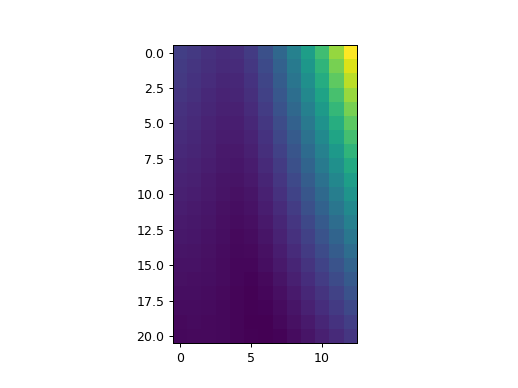

In [71]:
chi2_grid_mat = chi2_grid[:,:,0]

print(np.unravel_index(chi2_grid_mat.argmin(), chi2_grid_mat.shape))
print(chi2_grid_mat[20,6], c1_grid[20], c2_grid[6])
plt.imshow(chi2_grid_mat)
plt.show()

In [73]:
env_optim = Environment(c1=1.05, c2=1.0) # based on grid search result
mea = Measurement(q = np.squeeze(h5['q_SAD'][:])) # copied from previous cell



In [75]:
XS = traj_calc(traj, env_optim, mea, "frame_XS_calc_fast")
XS_avg = np.mean(XS, axis=0)
chi2_fun = lambda x: np.sqrt(np.mean( ((XS_avg - (F_st.S_exp * x[0] + x[1]))/F_st.S_err)**2 ))
res = minimize(chi2_fun, (1,0), method='CG')
print(res.x)

Done in 2.7233 seconds
[145102.41233073   1527.29416213]


<IPython.core.display.Javascript object>


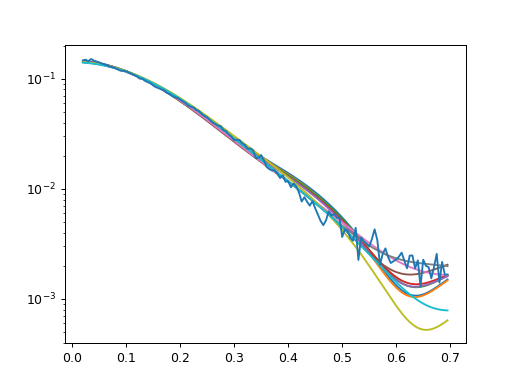

In [92]:
XS_scaled = (XS-res.x[1])/res.x[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(mea.q, np.transpose(XS_scaled))
ax.plot(F_st.q, F_st.S_exp)
ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

In [42]:
N = len(traj.Frames)

frame_init_iter = []
for i in np.arange(N):
        frame_init_iter.append((traj.Frames[i], env, mea))
    
print(np.shape(frame_init_iter))


(20, 3)


In [43]:
# Try multiprocessing in test slice
import multiprocessing as mp
import time

tic = time.time()

if __name__ == '__main__':
    p = mp.Pool(processes=8)
    res = p.starmap(frame_XS_calc, frame_init_iter )

# for process in process_list:
#     process.join()
    
toc = time.time()

print('Done in {:.4f} seconds'.format(toc-tic))
print(np.shape(res))

Done in 4.1749 seconds
(20, 136)


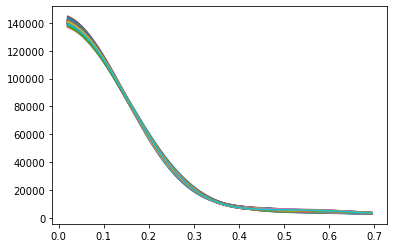

In [33]:
plt.figure()
plt.plot(mea.q, XS.T)
plt.show()

In [8]:
frame = traj.Frames[0]
traj = Trajectory(U, selection='protein', match_FoXS=False)
env = Environment(c2=0)
mea = Measurement(q = np.linspace(0.00, 0.5, num=501))
frame.SASA_calc(env)

FF_q = FF_calc(frame, env, mea)

# an i by j matrix of distances between all atoms
d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

XS = np.zeros(np.shape(mea.q))
for i in np.arange(frame.mol.n_atoms):
    for j in np.arange(i+1, frame.mol.n_atoms):
        qd = mea.q * d_ij[i,j]
        XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
    XS += FF_q[i] ** 2

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein has 304 atoms
The protein 

62104.596429024314


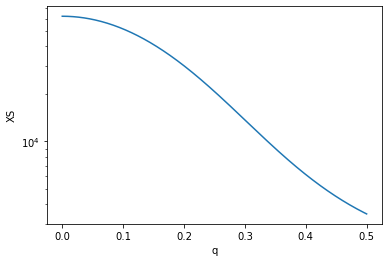

In [9]:
print(XS[0])
plt.figure()
plt.plot(mea.q, XS)
plt.ylabel('XS')
plt.xlabel('q')
plt.yscale('log')
plt.show()

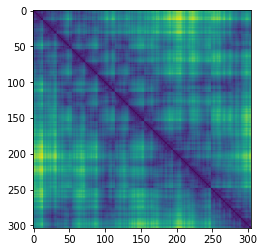

In [11]:
plt.imshow(d_ij)
plt.show()

In [12]:
def frame_XS_calc(frame, env, mea, ignoreSASA=False): # Calculate the X-ray scattering of a frame
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)

    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    
    # an i by j matrix of distances between all atoms
    d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

    # Calculate scattering signal XS
    XS = np.zeros(np.shape(mea.q))
    for i in np.arange(frame.mol.n_atoms):
        for j in np.arange(frame.mol.n_atoms-1)+1:
            qd = mea.q * d_ij[i,j]
            XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
        XS += FF_q[i] ** 2

    return XS

In [13]:
XS = frame_XS_calc(traj.Frames[0], env, mea)

In [14]:
XS[0]

122964.92185112403

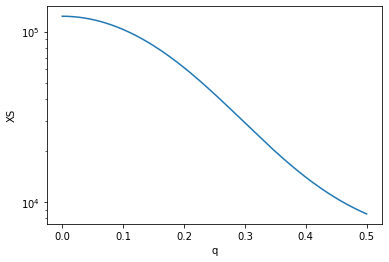

In [15]:
plt.figure()
plt.plot(mea.q, XS)
plt.ylabel('XS')
plt.xlabel('q')
plt.yscale('log')
plt.show()

C:\Users\achan\AppData\Local\Temp/ipykernel_4720/1087426951.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(mea.q),np.log(XS))


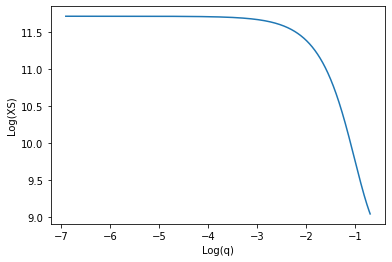

In [16]:
plt.plot(np.log(mea.q),np.log(XS))
plt.ylabel('Log(XS)')
plt.xlabel('Log(q)')
plt.show()